# ***Physics-Informed Anomaly Detection for EV Battery Degradation and Thermal System Analysis***

In [20]:
# Libraries 
import numpy as np 
import pandas as pd 
import os, glob
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

In [4]:
# Loading directory and files 
data_dir = "/kaggle/input/battery-and-heating-data-in-real-driving-cycles"
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and not f.startswith('.')]
print(f"Total CSV files found: {len(csv_files)}")

Total CSV files found: 70


### From the overivew file that all the trips that are in TripA**.csv are in same weather conditions, in order to keep the external conditions same for our project we will utilise only trips under same conditions. 


In [8]:
# loading a sample file as a dataframe
TripA01 = os.path.join(data_dir, "TripA01.csv")
df_TripA01 = pd.read_csv(TripA01, sep=";", encoding="ISO-8859-1")

In [9]:
df_TripA01.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [12]:
df_TripA01.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]'],
      dtype='object')

### Exploratry data analysis on few sample files 


In [21]:
# Focuing on trips with same weather conditions i.e TripA**
data_path = Path(data_dir)
trip_files = sorted(data_path.glob("TripA*.csv"))

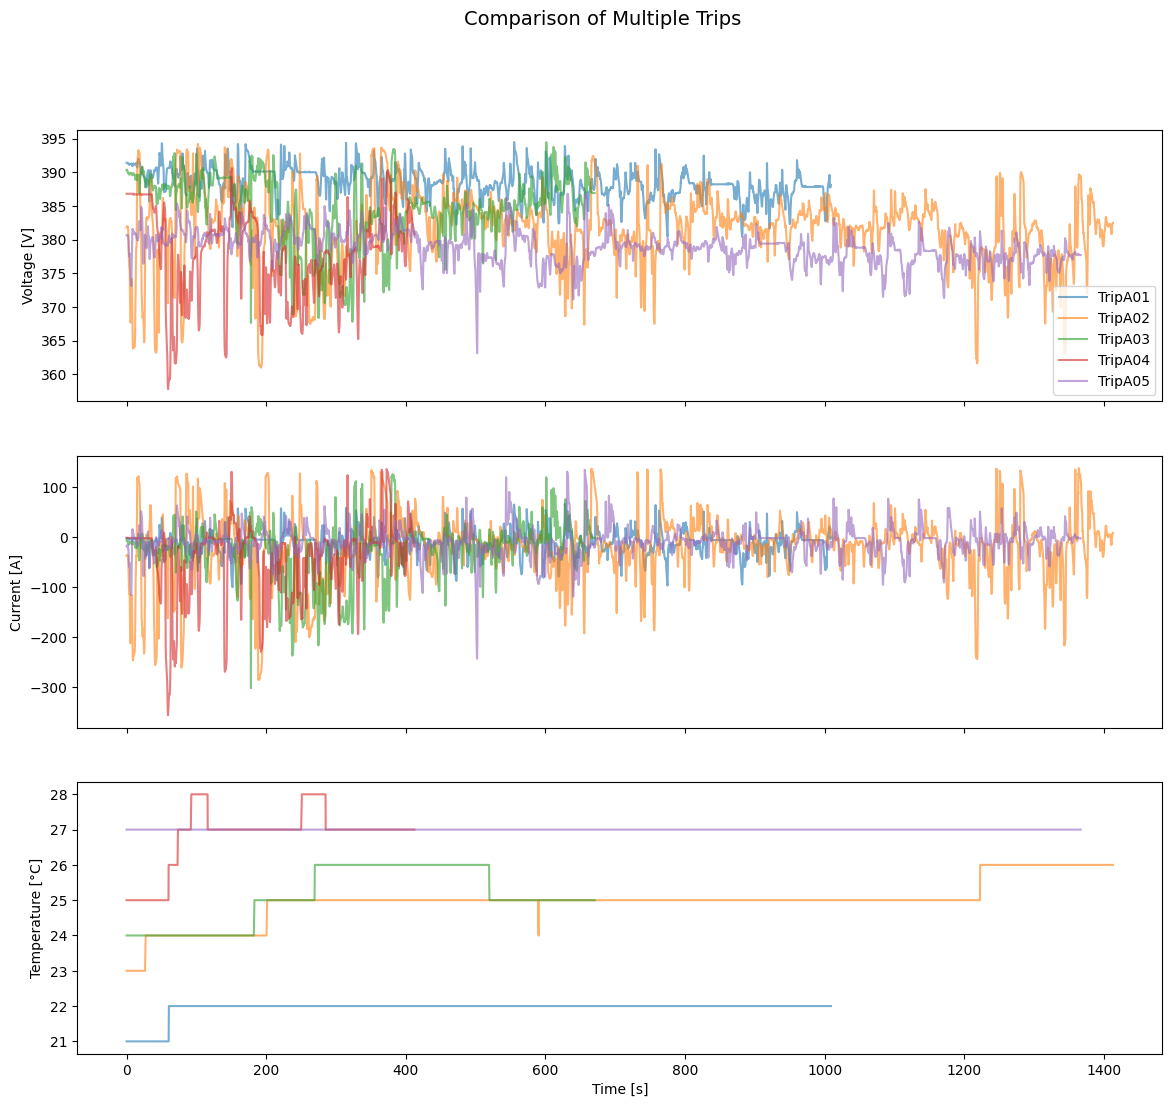

In [22]:
# Exploring Current['A'], Voltage['V'] and Battery Temperature [°C] related to our project. For clarity we are using first 5 trips only 
trip_files = sorted(data_path.glob("TripA*.csv"))

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
for trip_file in trip_files[:5]: 
    df_raw = pd.read_csv(trip_file, sep=";", encoding="ISO-8859-1")
    axes[0].plot(df_raw["Time [s]"], df_raw["Battery Voltage [V]"], alpha=0.6, label=trip_file.stem)
    axes[1].plot(df_raw["Time [s]"], df_raw["Battery Current [A]"], alpha=0.6)
    axes[2].plot(df_raw["Time [s]"], df_raw["Battery Temperature [°C]"], alpha=0.6)

axes[0].set_ylabel("Voltage [V]"); axes[0].legend()
axes[1].set_ylabel("Current [A]")
axes[2].set_ylabel("Temperature [°C]"); axes[2].set_xlabel("Time [s]")
plt.suptitle("Comparison of Multiple Trips", fontsize=14)
plt.show()



In above plots we can clearly see that battery temperature, current and voltage remain same for most of the trips but for some it shows anomalous behaviour. We are going to use unsupervised anomaly detection machine learning and then take deep dive into trips for further analysis. 

## Before creating a model we will do physics informed feature engineering that are related battery degradation and its thermal analysis 

In [23]:
def extract_battery_and_thermal_features(trip_data):
    features = {}
    try:
        #  Battery degradation criterion
        features['battery_voltage_std'] = trip_data['Battery Voltage [V]'].std()
        features['battery_current_std'] = trip_data['Battery Current [A]'].std()
        features['battery_temp_range'] = (
            trip_data['Battery Temperature [°C]'].max() - trip_data['Battery Temperature [°C]'].min()
        )

        soc_start = trip_data['SoC [%]'].iloc[0]
        soc_end   = trip_data['SoC [%]'].iloc[-1]
        trip_time = trip_data['Time [s]'].max()
        features['soc_drop_rate'] = (soc_start - soc_end) / trip_time
        

        #  Battery efficiency metrics 
        time_diff = np.diff(trip_data['Time [s]'])
        if len(time_diff) > 0:
            voltage = trip_data['Battery Voltage [V]']
            current = trip_data['Battery Current [A]']
            power   = voltage * current
            features['energy_consumption'] = np.trapz(power, trip_data['Time [s]']) / 3600.0
        else:
            features['energy_consumption'] = 0

        velocity_m_s = trip_data['Velocity [km/h]'] / 3.6
        features['distance'] = np.trapz(velocity_m_s, trip_data['Time [s]'])
        
        features['wh_per_km'] = (
            features['energy_consumption'] / (features['distance'] / 1000)
            if features['distance'] > 0 else 0
        )

        #  Thermal system performance 
        features['max_battery_temp'] = trip_data['Battery Temperature [°C]'].max()
        temp_gradient = np.gradient(trip_data['Battery Temperature [°C]'])
        features['temp_gradient_std'] = temp_gradient.std()

        heating_power_mean = trip_data['Heating Power CAN [kW]'].mean()
        if heating_power_mean > 0:
            features['heating_efficiency'] = (
                trip_data['Requested Heating Power [W]'].mean() / (heating_power_mean * 1000)
            )
        else:
            features['heating_efficiency'] = 0

    except Exception as e:
        print(f"Error in feature extraction: {e}")
        # Fallback defaults
        features.update({
            'battery_voltage_std': 0,
            'battery_current_std': 0,
            'battery_temp_range': 0,
            'soc_drop_rate': 0,
            'energy_consumption': 0,
            'distance': 0,
            'wh_per_km': 0,
            'max_battery_temp': 0,
            'temp_gradient_std': 0,
            'heating_efficiency': 0,
            'overheat_events': 0,
            'rapid_temp_change': 0
        })
    return features


In [26]:
# Extracting and calcuating the desired features as trip cycle in single file
feature_rows = []

for trip_file in sorted(data_path.glob("TripA*.csv")):
    try:
        trip_df = pd.read_csv(trip_file, sep=";", encoding="ISO-8859-1")  # adjust sep if needed
        feats = extract_battery_and_thermal_features(trip_df)
        feats["trip_id"] = trip_file.stem  # add TripA01, TripA02, ...
        feature_rows.append(feats)
    except Exception as e:
        print(f"Could not process {trip_file.name}: {e}")

# Final DataFrame with all trips
features_df = pd.DataFrame(feature_rows)

# Save to Kaggle working dir
features_df.to_csv("/kaggle/working/tripA_features.csv", index=False)
print("Saved tripA_features.csv with shape:", features_df.shape)

features_df.head()

Saved tripA_features.csv with shape: (32, 11)


,battery_voltage_std,battery_current_std,battery_temp_range,soc_drop_rate,energy_consumption,distance,wh_per_km,max_battery_temp,temp_gradient_std,heating_efficiency,trip_id
0,2.158318,22.799614,1.0,0.005352,-1289.180946,7427.689722,-173.564189,22.0,0.005290,1.982135,TripA01
1,5.228229,61.054705,3.0,0.009201,-2934.638790,23512.400278,-124.812386,26.0,0.009354,1.629824,TripA02
2,4.982608,54.344491,2.0,0.012528,-1954.406280,12820.846111,-152.439727,26.0,0.010718,0.418615,TripA03
3,6.393557,75.327144,3.0,0.020374,-1899.911044,10727.491389,-177.106741,28.0,0.020941,0.000000,TripA04
4,2.311075,27.144079,0.0,0.004756,-1504.166857,12393.621250,-121.366211,27.0,0.000000,0.226680,TripA05


In [27]:
#  Preparing new data for ML model 
df = features_df.copy()

# dropping unnecessary feature i.e trip_id
trip_ids = df["trip_id"]
X = df.drop(columns=["trip_id"])

# scaling features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

# Fit isolation forest to detect anomalies 
iso = IsolationForest(
    n_estimators=400,
    contamination=0.1,  
    random_state=42
)
anomaly_labels = iso.fit_predict(X_scaled)   
scores = iso.decision_function(X_scaled)


In [28]:
# Saving results as df 
df["anomaly"] = (anomaly_labels == -1)
df["anomaly_score"] = scores
df["trip_id"] = trip_ids

In [29]:
df.to_csv("/kaggle/working/tripA_anomalies.csv", index=False)
print("Saved anomaly detection results to tripA_anomalies.csv")

Saved anomaly detection results to tripA_anomalies.csv


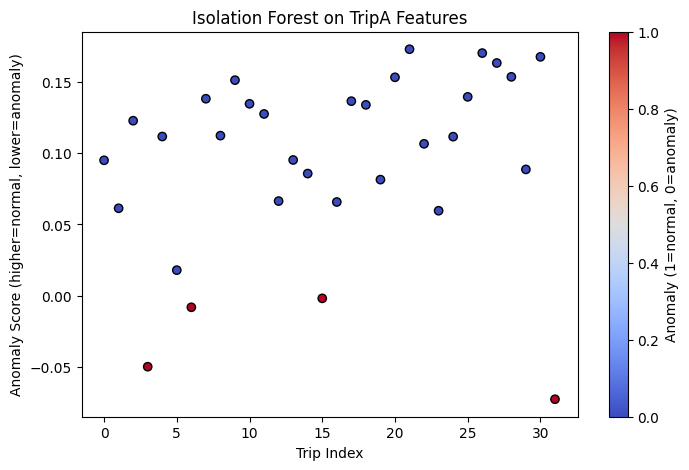

In [31]:
#  visualization 
plt.figure(figsize=(8,5))
plt.scatter(range(len(df)), df["anomaly_score"], 
            c=df["anomaly"], cmap="coolwarm", edgecolor="k")
plt.xlabel("Trip Index")
plt.ylabel("Anomaly Score (higher=normal, lower=anomaly)")
plt.title("Isolation Forest on TripA Features")
plt.colorbar(label="Anomaly (1=normal, 0=anomaly)")
plt.show()


### As we can see isolation forest has marked four trips as anomalies to further verify we will compare the marked trips with normal one. Please not that the hyperparameters for isolation forest are tuned with experimentation

In [33]:
# Filter only anomalous trips
anomalies = df[df["anomaly"] == 1][["trip_id", "anomaly_score"]]

print("Detected Anomalous Trips:")
print(anomalies)

Detected Anomalous Trips:
    trip_id  anomaly_score
3   TripA04      -0.050059
6   TripA07      -0.008268
15  TripA16      -0.001983
31  TripA32      -0.072929


Comparing anomalous trip: TripA32 vs normal trip: TripA22
Comparing anomalous trip: TripA32 vs normal trip: TripA22


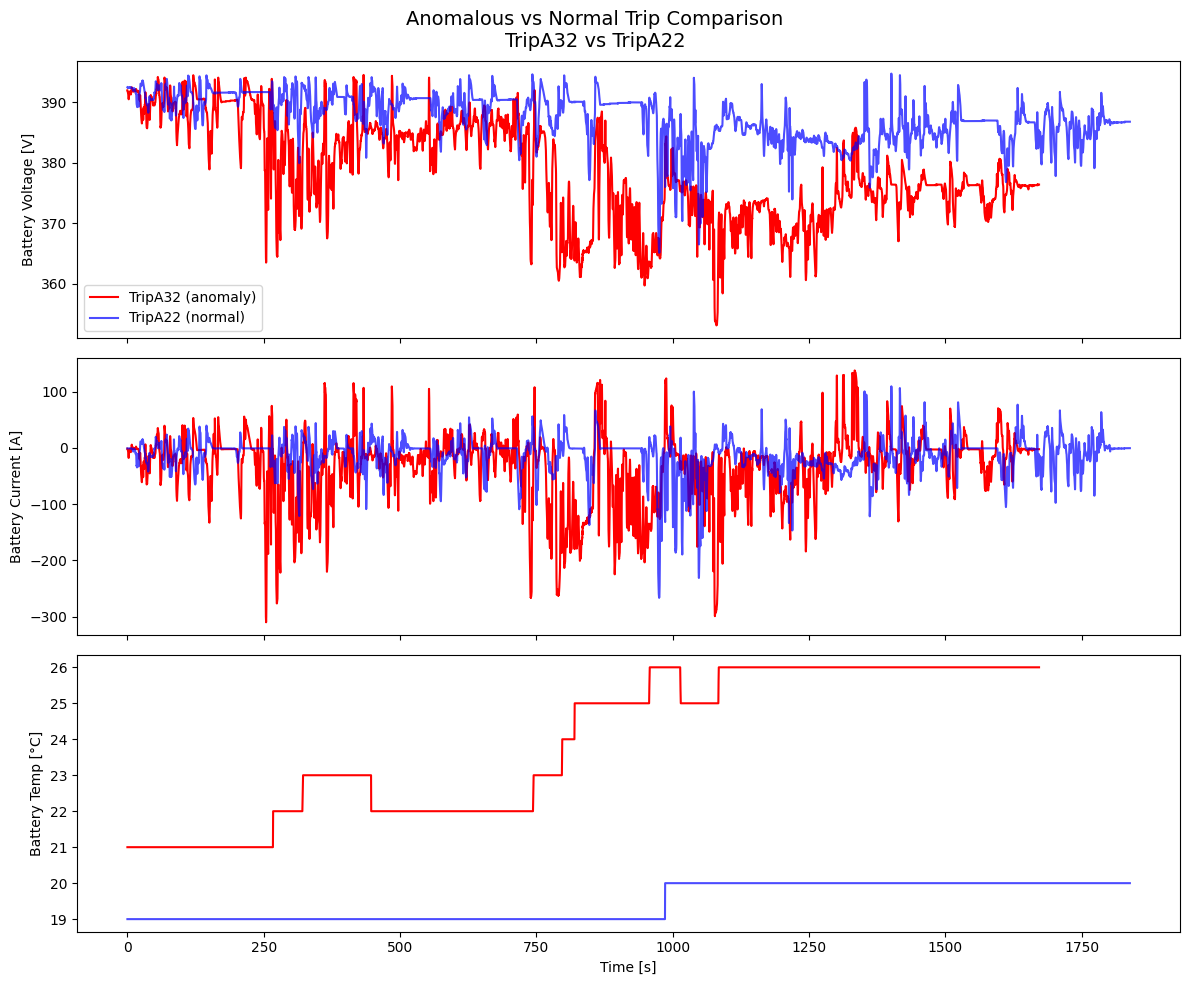

In [34]:
# Comparing anolamous trip with normal trip 

anom_row = df.loc[df["anomaly"] == 1].nsmallest(1, "anomaly_score").iloc[0]
anom_trip = anom_row["trip_id"]

# normal with highest score
norm_row = df.loc[df["anomaly"] == 0].nlargest(1, "anomaly_score").iloc[0]
norm_trip = norm_row["trip_id"]

print(f"Comparing anomalous trip: {anom_trip} vs normal trip: {norm_trip}")

print(f"Comparing anomalous trip: {anom_trip} vs normal trip: {norm_trip}")

# load the raw CSVs
anom_file = data_path / f"{anom_trip}.csv"
norm_file = data_path / f"{norm_trip}.csv"

anom_df = pd.read_csv(anom_file, sep=";", encoding="ISO-8859-1")
norm_df = pd.read_csv(norm_file, sep=";", encoding="ISO-8859-1")

# === Plot comparison ===
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Voltage
axes[0].plot(anom_df["Time [s]"], anom_df["Battery Voltage [V]"], label=f"{anom_trip} (anomaly)", color="red")
axes[0].plot(norm_df["Time [s]"], norm_df["Battery Voltage [V]"], label=f"{norm_trip} (normal)", color="blue", alpha=0.7)
axes[0].set_ylabel("Battery Voltage [V]")
axes[0].legend()

# Current
axes[1].plot(anom_df["Time [s]"], anom_df["Battery Current [A]"], color="red")
axes[1].plot(norm_df["Time [s]"], norm_df["Battery Current [A]"], color="blue", alpha=0.7)
axes[1].set_ylabel("Battery Current [A]")

# Battery Temperature
axes[2].plot(anom_df["Time [s]"], anom_df["Battery Temperature [°C]"], color="red")
axes[2].plot(norm_df["Time [s]"], norm_df["Battery Temperature [°C]"], color="blue", alpha=0.7)
axes[2].set_ylabel("Battery Temp [°C]")
axes[2].set_xlabel("Time [s]")

plt.suptitle(f"Anomalous vs Normal Trip Comparison\n{anom_trip} vs {norm_trip}", fontsize=14)
plt.tight_layout()
plt.show()

A direct comparison between TripA32 (anomalous) and TripA22 (normal) highlights the differences in electrical and thermal behavior. In TripA32, the battery voltage profile is consistently lower and exhibits frequent dips, indicating voltage sag under load, whereas TripA22 maintains a higher and more stable voltage across the trip. The battery current in the anomalous trip shows strong fluctuations and pronounced negative discharge spikes, reflecting unstable power flow, while the normal trip demonstrates smoother, more controlled current variations. Furthermore, the battery temperature in TripA32 rises in a stepwise fashion, reaching approximately 26 °C, compared to TripA22, where temperature remains stable around 20 °C throughout the cycle. These combined patterns of voltage instability, erratic current, and elevated temperature provide clear evidence of abnormal operating conditions in TripA32, in contrast to the stable performance observed in TripA22.

## In the last I would to compare overall overview of all the normal trips with anolomous by using average

In [35]:
# Get anomaly and normal trip IDs
anom_ids = df.loc[df["anomaly"] == 1, "trip_id"].tolist()
norm_ids = df.loc[df["anomaly"] == 0, "trip_id"].tolist()

def load_trip(trip_id):
    f = data_path / f"{trip_id}.csv"
    return pd.read_csv(f, sep=";", encoding="ISO-8859-1")

# Pick common time axis (0 → 1800s, step 1s for resampling)
time_axis = np.arange(0, 1800, 1)

# Using interpolation to make all the trips as same length
def interpolate_signal(trip_df, col, time_axis):
    """Resample/interpolate signal to common time_axis."""
    if col not in trip_df.columns:
        return np.full_like(time_axis, np.nan, dtype=float)
    t = pd.to_numeric(trip_df["Time [s]"], errors="coerce")
    y = pd.to_numeric(trip_df[col], errors="coerce")
    return np.interp(time_axis, t.dropna(), y.dropna(), left=np.nan, right=np.nan)



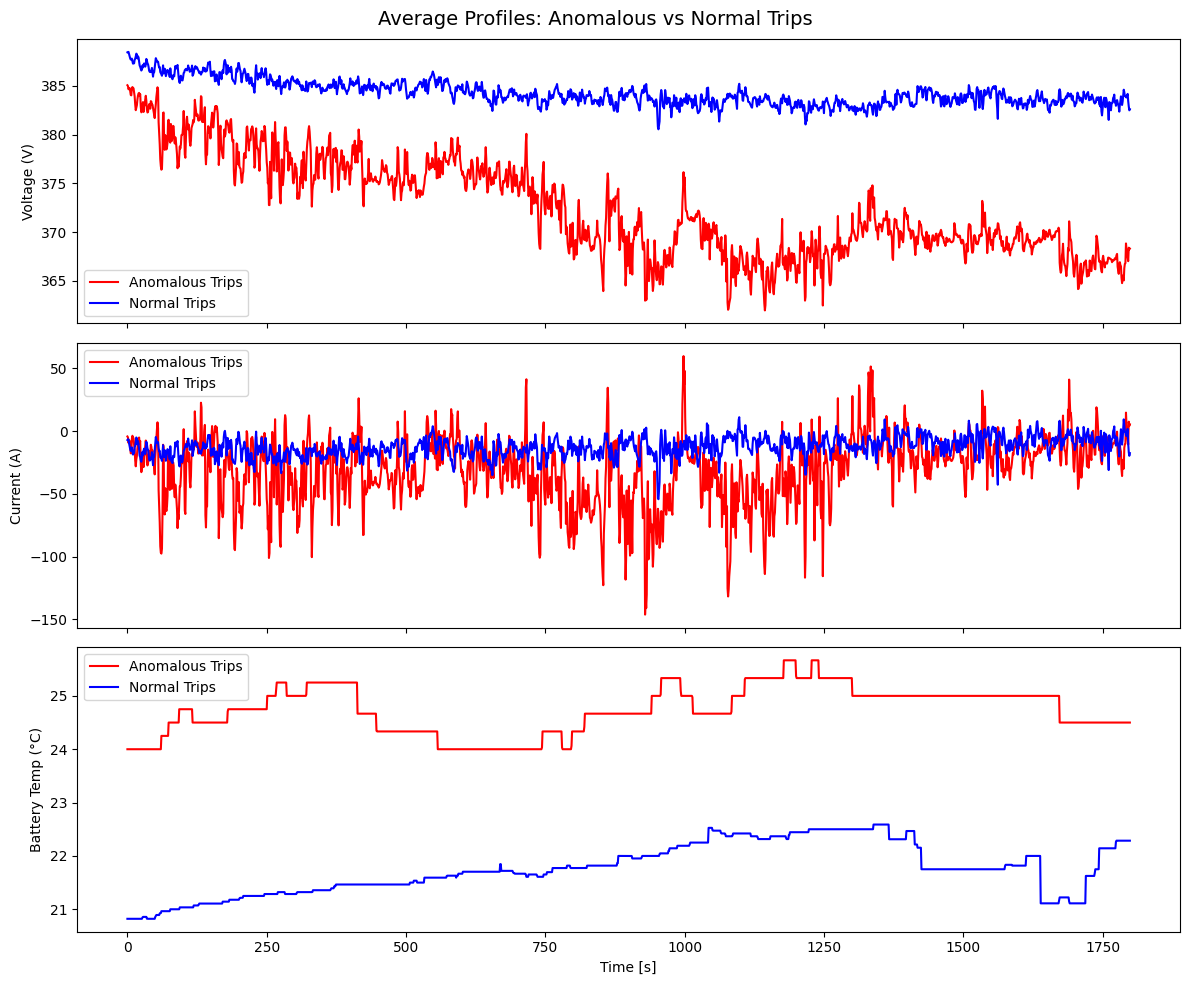

In [36]:
# Build average profiles
def compute_mean_profile(trip_ids, col):
    signals = []
    for tid in trip_ids:
        try:
            trip_df = load_trip(tid)
            sig = interpolate_signal(trip_df, col, time_axis)
            signals.append(sig)
        except Exception as e:
            print(f"⚠️ Skipping {tid}: {e}")
    if not signals:
        return np.full_like(time_axis, np.nan, dtype=float)
    return np.nanmean(np.vstack(signals), axis=0)

cols = {
    "Battery Voltage [V]": "Voltage (V)",
    "Battery Current [A]": "Current (A)",
    "Battery Temperature [°C]": "Battery Temp (°C)"
}

fig, axes = plt.subplots(len(cols), 1, figsize=(12, 10), sharex=True)

for ax, (raw_col, label) in zip(axes, cols.items()):
    mean_anom = compute_mean_profile(anom_ids, raw_col)
    mean_norm = compute_mean_profile(norm_ids, raw_col)
    
    ax.plot(time_axis, mean_anom, color="red", label="Anomalous Trips")
    ax.plot(time_axis, mean_norm, color="blue", label="Normal Trips")
    ax.set_ylabel(label)
    ax.legend()

axes[-1].set_xlabel("Time [s]")
plt.suptitle("Average Profiles: Anomalous vs Normal Trips", fontsize=14)
plt.tight_layout()
plt.show()


The figure above shows the average profiles of anomalous vs. normal trips for three key signals: battery voltage, current, and temperature. The results demonstrate clear differences between the two groups:
Voltage (top panel): Anomalous trips (red) exhibit lower and unstable voltage profiles with progressive sag, while normal trips (blue) maintain consistently higher and more stable voltage.
Current (middle panel): Anomalies show strong fluctuations and frequent deep negative spikes, reflecting unstable load and discharge events, whereas normal trips remain close to baseline with smoother current flow.
Temperature (bottom panel): In anomalous trips, the battery temperature rises quickly and remains elevated (25–26 °C), while in normal trips the increase is gradual and stays much lower (21–22 °C).

 In this project, we developed a physics-informed anomaly detection pipeline for electric vehicle (EV) battery trips using the Battery and Heating Data in Real Driving Cycles dataset. Our approach combined domain-relevant feature extraction with unsupervised learning (Isolation Forest) to identify anomalous trips based on both electrical and thermal behavior.

 **Conclusion:** The project demonstrates that physics-informed feature engineering, combined with anomaly detection, is an effective approach for identifying abnormal EV battery behavior. This framework can be extended for real-time monitoring in EV systems, improving safety and reliability.